<h1><center><b>Automatic Apparent Age Estimation </b></center></h1>

<h3><center>Prepared By: Adam Dudek & Mert Mecit</center></h3>

<h4> <b> 1) Introduction to the Problem & Dataset Preparation 

This assignment's aim is to regress people's age based on image. Apart from our accuracy on estimating age, we have some side goals of minimizing bias regarding age, gender, ethnicity and facial expression. We will be using Appa-Real Age Dataset for this purpose. It consists datas that have image, corresponding age and metadata of gender, ethnicity and facial expression.

Before starting our analysis, we install packages that we will be using throughout the project.

In [ ]:
!pip install tensorflow-gpu==2.4.0
!pip install opencv-python
!pip install h5py

     |████████████████████████████████| 394.7 MB 19 kB/s 
     |████████████████████████████████| 14.8 MB 32.3 MB/s 
     |████████████████████████████████| 2.9 MB 35.4 MB/s 
     |████████████████████████████████| 3.8 MB 40.2 MB/s 
     |████████████████████████████████| 462 kB 46.1 MB/s 
     |████████████████████████████████| 132 kB 50.7 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68717 sha256=f1dde0f8daba4f56cda6a4057fe296d92c39bee7dc52d623fe26e4efe3a3f141
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  A

Then, we install our data.

In [ ]:
# Downloading the data
!wget https://data.chalearnlap.cvc.uab.cat/Colab_2021/app_data.zip

# Decompressing the data
from zipfile import ZipFile

with ZipFile('app_data.zip','r') as zip:
   zip.extractall()
   print('Data decompressed successfully')

# Removing the .zip file after extraction to clean space
!rm app_data.zip

--2022-04-02 19:00:31--  https://data.chalearnlap.cvc.uab.cat/Colab_2021/app_data.zip
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 799021037 (762M) [application/zip]
Saving to: ‘app_data.zip’

app_data.zip        100%[===================>] 762.00M  23.1MB/s    in 50s     

2022-04-02 19:01:23 (15.1 MB/s) - ‘app_data.zip’ saved [799021037/799021037]

Data decompressed successfully


And, load our data and divide it into train, validation and test data. Also, we normalized train and validation data.

In [ ]:
import numpy as np

# loading the train data
X_train = np.load('./data/data_train.npy')
Y_train = np.load('./data/labels_train.npy')
M_train = np.load('./data/meta_data_train.npy')

# loading the validation data
X_valid = np.load('./data/data_valid.npy')
Y_valid = np.load('./data/labels_valid.npy')
M_valid = np.load('./data/meta_data_valid.npy')

# loading the test data
X_test = np.load('./data/data_test.npy')
Y_test = np.load('./data/labels_test.npy')
M_test = np.load('./data/meta_data_test.npy')

# train labels are real numbers, ranging from ~0.9 to ~89 (years old);
# we will re-scale the labels to [0,1] by using a normalization factor of 100,
# assuming there is no sample with age > 100.
Y_train = Y_train/100
Y_valid = Y_valid/100
# Y_test = Y_test/100 # -> we don't normalize the test labels as we will evaluate 
                      # them using the raw data, i.e., the apparent age values

print('Train data size and shape', X_train.shape)
print('Train labels size and shape', Y_train.shape)
print('Train metadata size and shape', M_train.shape)
print('----')
print('Valid data size and shape', X_valid.shape)
print('Valid labels size and shape', Y_valid.shape)
print('Valid metadata size and shape', M_valid.shape)
print('----')
print('Test data size and shape', X_test.shape)
print('Test labels size and shape', Y_test.shape)
print('Test metadata size and shape', M_test.shape)

Train data size and shape (4065, 224, 224, 3)
Train labels size and shape (4065,)
Train metadata size and shape (4065, 3)
----
Valid data size and shape (1482, 224, 224, 3)
Valid labels size and shape (1482,)
Valid metadata size and shape (1482, 3)
----
Test data size and shape (1978, 224, 224, 3)
Test labels size and shape (1978,)
Test metadata size and shape (1978, 3)


Now let's have a look at some examples.

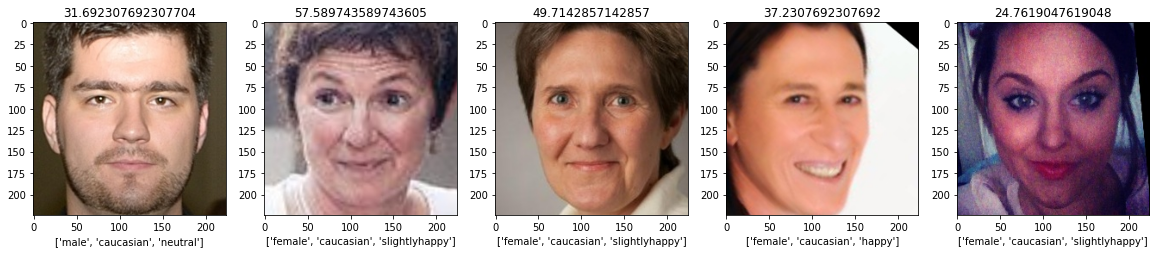

In [ ]:
import cv2
import random
from matplotlib import pyplot as plt
from cv2 import imshow

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))
for i, ax in enumerate(axes):
    idx = random.randint(0, len(X_train))
    ax.imshow(cv2.cvtColor(X_train[idx,:,:,:], cv2.COLOR_BGR2RGB))
    ax.set_title(Y_train[idx]*100)
    ax.set(xlabel=[M_train[idx][0],M_train[idx][1],M_train[idx][2]])

As our three candidate backbones are ResNet based, we will use preprocessing that is suitable for all three.

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

# train
for i in range(0,X_train.shape[0]):
  x = X_train[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_train[i,] = preprocess_input(x)

# validation
for i in range(0,X_valid.shape[0]):
  x = X_valid[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_valid[i,] = preprocess_input(x)  

# test
for i in range(0,X_test.shape[0]):
  x = X_test[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_test[i,] = preprocess_input(x)

<h4> <b> 2) Model Creation

<h5> <b> a) Backbone Selection

Here we define our three candidate models. All models are tried with same parameters (batch size, optimizer, learning rate, etc.) and initialized with same weights (random initalization). This is because pretraining methods and hypermarameter fine tuning is done in later steps. Note that the one that is selected (according to validation loss) is available in the code, rest is commented out.

In [ ]:
import h5py
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

'''
model_50 = tf.keras.applications.ResNet50(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax"
)
'''

model_101 = tf.keras.applications.ResNet101(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax"
)

'''
model_152 = tf.keras.applications.ResNet152(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax"
)
'''

'\nmodel_152 = tf.keras.applications.ResNet152(\n    include_top=True,\n    weights=None,\n    input_tensor=None,\n    input_shape=None,\n    pooling=None,\n    classes=1000,\n    classifier_activation="softmax"\n)\n'

Before comparing backbones, we should adapt the models according to our needs. Again, only preprocessing for the selected model is highlighted, other are commented.

In [ ]:
# Using the FC layer before the 'classifier_low_dim' layer as feature vector
#fc_512_50 = model_50.get_layer('predictions').output
fc_512_101 = model_101.get_layer('predictions').output
#fc_512_152 = model_152.get_layer('predictions').output

# Adding a dropout layer to minimize overfiting problems
#dp_layer_50 = Dropout(0.5)(fc_512_50)
dp_layer_101 = Dropout(0.5)(fc_512_101)
#dp_layer_152 = Dropout(0.5)(fc_512_152)

# Adding two hidden FC layers to learn hidden representations
#fc_128_50 = Dense(128, activation='relu', name='f_128')(fc_512_50)
#fc_32_50 = Dense(32, activation='relu', name='f_32')(fc_128_50)
fc_128_101 = Dense(128, activation='relu', name='f_128')(fc_512_101)
fc_32_101 = Dense(32, activation='relu', name='f_32')(fc_128_101)
#fc_128_152 = Dense(128, activation='relu', name='f_128')(fc_512_152)
#fc_32_152 = Dense(32, activation='relu', name='f_32')(fc_128_152)

# Including an additional FC layer with sigmoid activation, used to regress
# the apparent age
#output_50 = Dense(1, activation='sigmoid', name='predict')(fc_32_50)
output_101 = Dense(1, activation='sigmoid', name='predict')(fc_32_101)
#output_152 = Dense(1, activation='sigmoid', name='predict')(fc_32_152)

# Building and pringing the final model
#model_50 = Model(inputs=model_50.get_layer(index = 0).output,outputs=output_50)
model_101 = Model(inputs=model_101.get_layer(index = 0).output,outputs=output_101)
#model_152 = Model(inputs=model_152.get_layer(index = 0).output,outputs=output_152)

Then, we compare backbones based on validation loss. Here, Adam optimizer with a learning rate of 1e-5, batch size of 32 and 25 epochs are used to compare them. We used 50 epochs for each.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
from matplotlib import pyplot as plt

# Defining the early stop criteria
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Saving the best model based on val_loss
mc = ModelCheckpoint('/content/gdrive/MyDrive/temp/best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

# Defining the optimizer
#model_50.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])
model_101.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])
#model_152.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])

# Training the model
#history = model_50.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=32, epochs=25, shuffle=True, verbose=1, callbacks=[es,mc])
history = model_101.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=32, epochs=25, shuffle=True, verbose=1, callbacks=[es,mc])
#history = model_152.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=32, epochs=25, shuffle=True, verbose=1, callbacks=[es,mc])

# Saving training history (for future visualization)
with open('/content/gdrive/MyDrive/temp/train_history.pkl', 'wb') as handle:
  pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

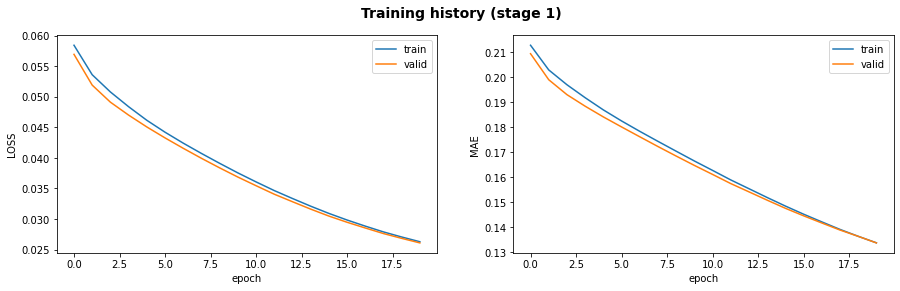

In [ ]:
train_hist = pickle.load(open("/content/gdrive/MyDrive/temp/train_history.pkl","rb"))

# we plot both, the LOSS and MAE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (stage 1)', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss'])
ax1.plot(train_hist['val_loss'])
ax1.set(xlabel='epoch', ylabel='LOSS')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae'])
ax2.plot(train_hist['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')
plt.show()

Based on the validation errors above, we are relatively inconclusive as with randomly selected weights, every model has somewhat similar final validation errors (after 50 epochs). Also, they all show potential to increase as we proceed with more epochs. However, due to time limitations we chose ResNet101 as it has almost the same validation loss with ResNet152, but it took %33 less to train it.

<br>
<table>
  <tr>
    <th>Model</th>
    <th>Final Validation Loss</th>
    <th>Execution Time (mins)</th>
  </tr>
  <tr>
    <td><center>ResNet50</center></td>
    <td><center>0.017</center></td>
    <td><center>60</center></td>
  </tr>
  <tr>
    <td><center>ResNet101</center></td>
    <td><center>0.014</center></td>
    <td><center>100</center></td>
  </tr>
  <tr>
    <td><center>ResNet152</center></td>
    <td><center>0.013</center></td>
    <td><center>150</center></td>
  </tr>
</table>

<h5> <b> b) Training Strategy Selection

Now we have decided our backbone and it is time to decide for a training strategy. Then, we will do hyperparameter fine tuning before our analysis. For now, they all have same hyperparameters (ADAM optimizer, 32 batch size, 1e-5 learning rate, 50 epochs).
<br>
We have chosen three different strategies for our training: <ol><li>
Train it as itself with 20 epochs.</li>
<li>Use pretrained weights from <b>ImageNet</b> and train only newly added layers.</li>
<li>Use pretrained weights from <b>ImageNet</b> and train whole model.</li></ol>

First one is already done above. We will now do the second one and have a look at whether we increased our validation accuracy.

In [ ]:
import h5py
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define model with imagenet pre-trained weights
model_101 = tf.keras.applications.ResNet101V2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

# Add layers to fit model into our problem just like above.
fc_512_101 = model_101.get_layer('predictions').output
dp_layer_101 = Dropout(0.5)(fc_512_101)
fc_128_101 = Dense(128, activation='relu', name='f_128')(fc_512_101)
fc_32_101 = Dense(32, activation='relu', name='f_32')(fc_128_101)
output_101 = Dense(1, activation='sigmoid', name='predict')(fc_32_101)
model_101 = Model(inputs=model_101.get_layer(index = 0).output,outputs=output_101)

# Freeze only added layers (this part is commented out while training model 3 is applied)
counter = 0
for layer in model_101.layers:
  if counter <= 377: 
    layer.trainable = False
  else:
    layer.trainable = True
  counter +=1

# Define optimizer & train added layers
model_101.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])
history = model_101.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=32, epochs=25, shuffle=True, verbose=1, callbacks=[es,mc])

Epoch 1/25
128/128 [==============================] - 67s 463ms/step - loss: 0.0584 - mae: 0.2127 - val_loss: 0.0564 - val_mae: 0.2083
Epoch 2/25
128/128 [==============================] - 57s 443ms/step - loss: 0.0553 - mae: 0.2064 - val_loss: 0.0538 - val_mae: 0.2029
Epoch 3/25
128/128 [==============================] - 57s 443ms/step - loss: 0.0528 - mae: 0.2013 - val_loss: 0.0514 - val_mae: 0.1980
Epoch 4/25
128/128 [==============================] - 57s 443ms/step - loss: 0.0503 - mae: 0.1959 - val_loss: 0.0489 - val_mae: 0.1924
Epoch 5/25
128/128 [==============================] - 57s 443ms/step - loss: 0.0476 - mae: 0.1902 - val_loss: 0.0462 - val_mae: 0.1866
Epoch 6/25
128/128 [==============================] - 57s 443ms/step - loss: 0.0450 - mae: 0.1842 - val_loss: 0.0437 - val_mae: 0.1809
Epoch 7/25
128/128 [==============================] - 57s 443ms/step - loss: 0.0427 - mae: 0.1789 - val_loss: 0.0415 - val_mae: 0.1760
Epoch 8/25
128/128 [==============================] - 5

In [ ]:
# Unfreeze all layers
counter = 0
for layer in model_101.layers:
    layer.trainable = True

# Define optimizer & train added layers
model_101.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])
history = model_101.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=32, epochs=25, shuffle=True, verbose=1, callbacks=[es,mc])

Epoch 1/25
128/128 [==============================] - 164s 1s/step - loss: 0.0371 - mae: 0.1653 - val_loss: 0.0343 - val_mae: 0.1577
Epoch 2/25
128/128 [==============================] - 149s 1s/step - loss: 0.0305 - mae: 0.1469 - val_loss: 0.0238 - val_mae: 0.1240
Epoch 3/25
128/128 [==============================] - 151s 1s/step - loss: 0.0223 - mae: 0.1213 - val_loss: 0.0195 - val_mae: 0.1097
Epoch 4/25
128/128 [==============================] - 152s 1s/step - loss: 0.0176 - mae: 0.1043 - val_loss: 0.0172 - val_mae: 0.1019
Epoch 5/25
128/128 [==============================] - 151s 1s/step - loss: 0.0146 - mae: 0.0916 - val_loss: 0.0164 - val_mae: 0.0984
Epoch 6/25
128/128 [==============================] - 151s 1s/step - loss: 0.0130 - mae: 0.0840 - val_loss: 0.0157 - val_mae: 0.0963
Epoch 7/25
128/128 [==============================] - 151s 1s/step - loss: 0.0121 - mae: 0.0790 - val_loss: 0.0153 - val_mae: 0.0949
Epoch 8/25
128/128 [==============================] - 152s 1s/step - 

Again we draw our graphs.

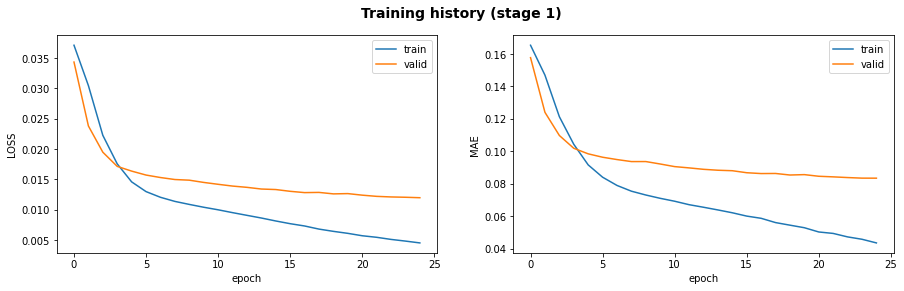

In [ ]:
with open('/content/gdrive/MyDrive/temp/train_history.pkl', 'wb') as handle:
  pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

train_hist = pickle.load(open("/content/gdrive/MyDrive/temp/train_history.pkl","rb"))

# we plot both, the LOSS and MAE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (stage 1)', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss'])
ax1.plot(train_hist['val_loss'])
ax1.set(xlabel='epoch', ylabel='LOSS')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae'])
ax2.plot(train_hist['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')
plt.show()

We applied 3 different training strategies for the medol we decided on the first part. They all have room for improvement with higher amount of epochs. Although strategy 3 (pretraining with Imagenet without freeze) have a final validation loss that is the lowest, it takes %150 more time to perform it when compared to strategy 2 (pretraining with ImageNet with freeze). So, considering we will be using sufficient amount of epochs at the end, we will be using strategy 2 as it has significantly lower execution time but only a little worse final validation loss.

<br>
<table>
  <tr>
    <th>Training Strategy</th>
    <th>Final Validation Loss</th>
    <th>Execution Time (mins)</th>
  </tr>
  <tr>
    <td><center>1) No Pretraining</center></td>
    <td><center>0.014</center></td>
    <td><center>100</center></td>
  </tr>
  <tr>
    <td><center>2) Pretraining with Freeze</center></td>
    <td><center>0.010</center></td>
    <td><center>75</center></td>
  </tr>
  <tr>
    <td><center>3) Pretraining without Freeze</center></td>
    <td><center>0.010</center></td>
    <td><center>100</center></td>
  </tr>
</table>

<h5> <b> c) Hyperparameter Tuning

We have our backbone and training strategy. Now it is time to fine-tune our hyperparameters. The hyperparameters that we are going to fine tune are:
<ol>
<li>Batch Size</li>
<li>Optimizer</li>
<li>Learning Rate</li>
</ol>
Epoch rate is not considered as a hyperparameter here as in the final model we will have high enough epochs to saturate the model.
Regarding the listed hyperparameters, as we have limited time, we only tried 3 different numbers or types. While we try other hyperparameters, default hyperparameters are optimizer = Adam, batch size = 32, learning rate = 1e-5.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam, SGD, Adadelta

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

mc = ModelCheckpoint('/content/gdrive/MyDrive/temp/best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

#Different Batch Sizes

#model_101.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])
#history = model_101.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=16, epochs=25, shuffle=True, verbose=1, callbacks=[es,mc])
#history = model_101.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=64, epochs=25, shuffle=True, verbose=1, callbacks=[es,mc])

#Different Optimizers

#model_101.compile(tf.keras.optimizers.SGD(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])
#model_101.compile(tf.keras.optimizers.Adadelta(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])
#history = model_101.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=32, epochs=25, shuffle=True, verbose=1, callbacks=[es,mc])

#Different Learning Rates

#model_101.compile(tf.keras.optimizers.Adam(learning_rate=1e-4),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])
model_101.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])
history = model_101.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=32, epochs=25, shuffle=True, verbose=1, callbacks=[es,mc])

Epoch 1/20
128/128 [==============================] - 74s 483ms/step - loss: 0.0582 - mae: 0.2129 - val_loss: 0.0552 - val_mae: 0.2059
Epoch 2/20
128/128 [==============================] - 60s 471ms/step - loss: 0.0542 - mae: 0.2048 - val_loss: 0.0521 - val_mae: 0.1995
Epoch 3/20
128/128 [==============================] - 60s 471ms/step - loss: 0.0530 - mae: 0.2021 - val_loss: 0.0493 - val_mae: 0.1934
Epoch 4/20
128/128 [==============================] - 60s 471ms/step - loss: 0.0483 - mae: 0.1921 - val_loss: 0.0467 - val_mae: 0.1878
Epoch 5/20
128/128 [==============================] - 60s 470ms/step - loss: 0.0464 - mae: 0.1867 - val_loss: 0.0443 - val_mae: 0.1824
Epoch 6/20
128/128 [==============================] - 60s 471ms/step - loss: 0.0433 - mae: 0.1804 - val_loss: 0.0421 - val_mae: 0.1772
Epoch 7/20
128/128 [==============================] - 60s 470ms/step - loss: 0.0418 - mae: 0.1772 - val_loss: 0.0396 - val_mae: 0.1714
Epoch 8/20
128/128 [==============================] - 6

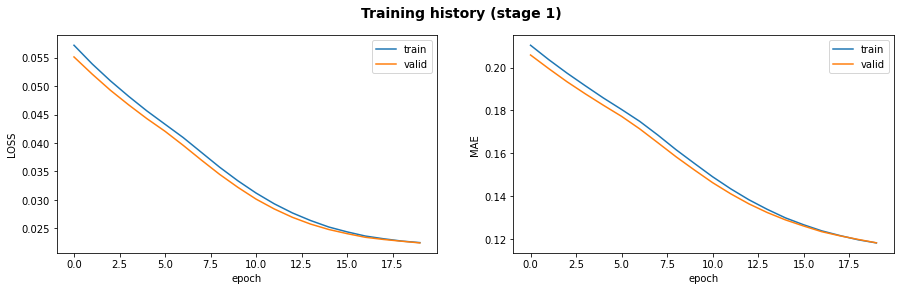

In [ ]:
with open('/content/gdrive/MyDrive/temp/train_history.pkl', 'wb') as handle:
  pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

train_hist = pickle.load(open("/content/gdrive/MyDrive/temp/train_history.pkl","rb"))

# we plot both, the LOSS and MAE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (stage 1)', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss'])
ax1.plot(train_hist['val_loss'])
ax1.set(xlabel='epoch', ylabel='LOSS')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae'])
ax2.plot(train_hist['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')
plt.show()

In batch size, we tried 32, 16 and 64. 64 yielded a significantly bad result. 32 and 16 yielded good results and the graph of 16 showed us that its almost done improving, there were no much room for improvement. However, we both tried 32 and 16 in our next models.
<br>
<table>
  <tr>
    <th>Batch Size</th>
    <th>Final Validation Loss-</th>
    <th>Execution Time (mins)</th>
  </tr>
  <tr>
    <td><center>32</center></td>
    <td><center>0.010</center></td>
    <td><center>75</center></td>
  </tr>
  <tr>
    <td><center>16</center></td>
    <td><center>0.010 (Almost Saturated)</center></td>
    <td><center>75</center></td>
  </tr>
  <tr>
    <td><center>64</center></td>
    <td><center>0.016</center></td>
    <td><center>75</center></td>
  </tr>
</table>
<br>
We tried 3 optimizers: Adam, SGD and AdaDelta. ADAM was strictly the best both in terms of final validation loss and execution time, so we keep our analysis with it.
<br>
<table>
  <tr>
    <th>Optimizer</th>
    <th>Final Validation Loss</th>
    <th>Execution Time (mins)</th>
  </tr>
  <tr>
    <td><center>ADAM</td>
    <td><center>0.10</center></td>
    <td><center>75</center></td>
  </tr>
  <tr>
    <td><center>SGD</center></td>
    <td><center>0.021</center></td>
    <td><center>75</center></td>
  </tr>
  <tr>
    <td><center>AdaDelta</center></td>
    <td><center>0.022</center></td>
    <td><center>75</center></td>
  </tr>
</table>
<br>
We tried 3 learning rates: 1e-5, 1e-4 and 1e-6. 1e-6 yielded the worst result. Between 1e-4 and 1e-5, their validation losses were almost similar at the end of the analysis. However, 1e-4's early stopping mechanism was triggered, however, with 1e-5, we still had toom for improvement. As we want to add more epochs in our final analysis, we will keep our 1e-5 learning rate.
<br>
<table>
  <tr>
    <th>Learning Rate</th>
    <th>Final Validation Loss</th>
    <th>Execution Time (mins)</th>
  </tr>
  <tr>
    <td><center>1e-5</center></td>
    <td><center>0.010</center></td>
    <td><center>75</center></td>
  </tr>
  <tr>
    <td><center>1-e4</center></td>
    <td><center>0.016 (Early stopped @15)</center></td>
    <td><center>22</center></td>
  </tr>
  <tr>
    <td><center>1e-6</center></td>
    <td><center>0.021</center></td>
    <td><center>75</center></td>
  </tr>
</table>

<h4> <b> 3) Loss Function Selection



After deciding on our backbone, training strategy and hyperparameters, now we are proceeding to try different loss functions to improve our model. We have only tried MeanSquaredError (MSE) so far. The ones we have also tried are given as follows, all are tried with the strategy above (25 epochs with frozen layers + 25 layers with full model).

<ol>
<li> Mean Squared Error (Our default)
<li> Sparse Categorical Cross Entropy
<li> Poisson
<li> Huber
<li> LogCosh
<li> Mean Squared Logarithmic Error
<li> Mean Absolute Percentage Error 
</ol>

From now on, we will give our decisions based on both validation loss as well as biases (age, ethnicity, face and gender). 

In [ ]:
import h5py
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
from matplotlib import pyplot as plt

# Defining the early stop criteria
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Saving the best model based on val_loss
mc = ModelCheckpoint('/content/gdrive/MyDrive/temp/best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

# Define model with imagenet pre-trained weights
model_101 = tf.keras.applications.ResNet101V2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

# Add layers to fit model into our problem just like above.
fc_512_101 = model_101.get_layer('predictions').output
dp_layer_101 = Dropout(0.5)(fc_512_101)
fc_128_101 = Dense(128, activation='relu', name='f_128')(fc_512_101)
fc_32_101 = Dense(32, activation='relu', name='f_32')(fc_128_101)
output_101 = Dense(1, activation='sigmoid', name='predict')(fc_32_101)
model_101 = Model(inputs=model_101.get_layer(index = 0).output,outputs=output_101)

# Training Stage - 1

# Freeze only added layers (this part is commented out while training model 3 is applied)
counter = 0
for layer in model_101.layers:
  if counter <= 377: 
    layer.trainable = False
  else:
    layer.trainable = True
  counter +=1

# Define optimizer & train added layers

#model_101.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])
#model_101.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['mae'])
#model_101.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.Poisson(),metrics=['mae'])
#model_101.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.Huber(),metrics=['mae'])
#model_101.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.LogCosh(),metrics=['mae'])
#model_101.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredLogarithmicError(),metrics=['mae'])
model_101.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanAbsolutePercentageError(),metrics=['mae'])
history = model_101.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=32, epochs=25, shuffle=True, verbose=1, callbacks=[es,mc])

# Training Stage - 2

# Unfreeze all layers
counter = 0
for layer in model_101.layers:
    layer.trainable = True

# Define optimizer & train added layers

#model_101.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])
#model_101.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['mae'])
#model_101.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.Poisson(),metrics=['mae'])
#model_101.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.Huber(),metrics=['mae'])
#model_101.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.LogCosh(),metrics=['mae'])
#model_101.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredLogarithmicError(),metrics=['mae'])
model_101.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanAbsolutePercentageError())
history = model_101.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=32, epochs=25, shuffle=True, verbose=1, callbacks=[es,mc])

Results are discussed in the report. Here, we found that Mean absolute percentage error yields the best result in terms of MAE and LogCosh does good job on different biases. So, for our final model, we tried them, as well as our main model that is with MSE.

<h4> <b> 4) Playin with Weights

We also considered looking at different weights and applied those weights on the models that we found the best above and compare our results.

We created 4 different sets of weights: for age, for face expression, ethnicity and gender. We checked sizes of subgroups in our dataset and we saw, that there are some big disproportions within groups:
<ul>
<li>Age: 796 people <20yo , 2389 people from 20yo to 40yo, 732 people from 40 to 60 and 148 people older than 60 yo.
<li>Gender: 2068 males and 1997 females.
<li>Face expression: 1404 neutral face expression, 712 happy, 1784 slightly happy and 165 with other face expressions.
<li>Ethnicity: 3522 caucasian, 119 afroamerican and 424 asians. 
</ul>

That’s why we decided to check results for the best models from previous part (models with LogCosh, MeanAbsolutePercentageError and MSE loss functions) with different weights.


In [ ]:
#Here we run different weights for the model anchh check the results
from tensorflow.keras.applications.resnet50 import preprocess_input
# loading the train data again (original face images, before preprocessing):
X_train = np.load('./data/data_train.npy')
Y_train = np.load('./data/labels_train.npy')
Y_train = Y_train/100 # normalizing the age values to be between [0,1]

# Preprocessing the train data with respect to ResNet-50 Inputs.
for i in range(0,X_train.shape[0]):
  x = X_train[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_train[i,] = preprocess_input(x)

# Counting the number of samples per group in the train data (age attribute only)
g1 = g2 = g3 = g4 = 0
for i in range(0,Y_train.shape[0]):
    if(Y_train[i]*100<20):
      g1 +=1
    if(Y_train[i]*100>=20 and Y_train[i]*100<40):
      g2 +=1
    if(Y_train[i]*100>=40 and Y_train[i]*100<60):
      g3 +=1
    if(Y_train[i]*100>=60):
      g4 +=1
print('group(s) size = ', [g1, g2, g3, g4])

g1_eth= g2_eth=g3_eth = 0
for i in range(0,M_train.shape[0]):
    if(M_train[i][1]=='caucasian'):
      g1_eth +=1
    if(M_train[i][1]=='afroamerican'):
      g2_eth +=1
    if(M_train[i][1]=='asian'):
      g3_eth +=1
print('group(s) size = ', [g1_eth, g2_eth, g3_eth])

g1_male= g2_female = 0
for i in range(0,M_train.shape[0]):
    if(M_train[i][0]=='male'):
      g1_male +=1
    if(M_train[i][0]=='female'):
      g2_female +=1
print('group(s) size = ', [g1_male, g2_female])

# Counting the number of samples per group in the train data (age attribute only)
g1_face = g2_face = g3_face = g4_face = 0
for i in range(0,M_train.shape[0]):
    if(M_train[i][2]=='neutral'):
      g1_face +=1
    if(M_train[i][2]=='happy'):
      g2_face +=1
    if(M_train[i][2]=='slightlyhappy'):
      g3_face +=1
    if(M_train[i][2]=='other'):
      g4_face +=1
print('group(s) size = ', [g1_face, g2_face, g3_face, g4_face])

# Generating the weights for each group using the equation defined above
w_age = sum(np.array([g1, g2, g3, g4]))/(4*np.array([g1, g2, g3, g4]))
print('weights per age group = ', w_age)

# Generating the weights for each group using the equation defined above
w_gender = sum(np.array([g1_male, g2_female]))/(2*np.array([g1_male, g2_female]))
print('weights per gender group = ', w_gender)

# Generating the weights for each group using the equation defined above
w_eth = sum(np.array([g1_eth, g2_eth, g3_eth]))/(3*np.array([g1_eth, g2_eth, g3_eth]))
print('weights per ethnicty group = ', w_eth)

# Generating the weights for each group using the equation defined above
w_face = sum(np.array([g1_face, g2_face, g3_face, g4_face]))/(4*np.array([g1_face, g2_face, g3_face, g4_face]))
print('weights per face expression group = ', w_face)

# Creating a vector with same size as Y_train, that will link a particular label to its weight
sample_weights_age = []
for i in range(0,Y_train.shape[0]):
    if(Y_train[i]*100<20):
      sample_weights_age.append(w_age[0])
    if(Y_train[i]*100>=20 and Y_train[i]*100<40):
      sample_weights_age.append(w_age[1])
    if(Y_train[i]*100>=40 and Y_train[i]*100<60):
      sample_weights_age.append(w_age[2])
    if(Y_train[i]*100>=60):
      sample_weights_age.append(w_age[3])
sample_weights_age = np.array(sample_weights_age)

# Creating a vector with same size as Y_train, that will link a particular label to its weight
sample_weights_gender = []
for i in range(0,M_train.shape[0]):
    if(M_train[i][0]=='male'):
      sample_weights_gender.append(w_gender[0])
    if(M_train[i][0]=='female'):
      sample_weights_gender.append(w_gender[1])
sample_weights_gender = np.array(sample_weights_gender)


# Creating a vector with same size as Y_train, that will link a particular label to its weight
sample_weights_ethnicity = []
for i in range(0,M_train.shape[0]):
    if(M_train[i][1]=='caucasian'):
      sample_weights_ethnicity.append(w_eth[0])
    if(M_train[i][1]=='afroamerican'):
      sample_weights_ethnicity.append(w_eth[1])
    if(M_train[i][1]=='asian'):
      sample_weights_ethnicity.append(w_eth[2])
sample_weights_ethnicity= np.array(sample_weights_ethnicity)

sample_weights_face = []
for i in range(0,M_train.shape[0]):
    if(M_train[i][2]=='neutral'):
     sample_weights_face.append(w_face[0])
    if(M_train[i][2]=='happy'):
      sample_weights_face.append(w_face[1])
    if(M_train[i][2]=='slightlyhappy'):
      sample_weights_face.append(w_face[2])
    if(M_train[i][2]=='other'):
      sample_weights_face.append(w_face[3])
sample_weights_face= np.array(sample_weights_face)


group(s) size =  [796, 2389, 732, 148]
group(s) size =  [3522, 119, 424]
group(s) size =  [2068, 1997]
group(s) size =  [1404, 712, 1784, 165]
weights per age group =  [1.27669598 0.42538719 1.38831967 6.86655405]
weights per gender group =  [0.98283366 1.01777666]
weights per ethnicty group =  [ 0.38472459 11.38655462  3.19575472]
weights per face expression group =  [0.72382479 1.42731742 0.56964686 6.15909091]


In [ ]:
import h5py
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
from matplotlib import pyplot as plt

# Defining the early stop criteria
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Saving the best model based on val_loss
mc = ModelCheckpoint('/content/gdrive/MyDrive/temp/best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

# Define model with imagenet pre-trained weights
model_101 = tf.keras.applications.ResNet101V2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

# Add layers to fit model into our problem just like above.
fc_512_101 = model_101.get_layer('predictions').output
dp_layer_101 = Dropout(0.5)(fc_512_101)
fc_128_101 = Dense(128, activation='relu', name='f_128')(fc_512_101)
fc_32_101 = Dense(32, activation='relu', name='f_32')(fc_128_101)
output_101 = Dense(1, activation='sigmoid', name='predict')(fc_32_101)
model_101 = Model(inputs=model_101.get_layer(index = 0).output,outputs=output_101)

# Training Stage - 1

# Freeze only added layers (this part is commented out while training model 3 is applied)
counter = 0
for layer in model_101.layers:
  if counter <= 377: 
    layer.trainable = False
  else:
    layer.trainable = True
  counter +=1

# Define optimizer & train added layers

#model_101.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])
#model_101.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.LogCosh(),metrics=['mae'])
model_101.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanAbsolutePercentageError(),metrics=['mae'])
history = model_101.fit(X_train, Y_train, validation_data=(X_valid, Y_valid),sample_weight=sample_weights_gender, batch_size=32, epochs=25, shuffle=True, verbose=1, callbacks=[es,mc])

# Training Stage - 2

# Unfreeze all layers
counter = 0
for layer in model_101.layers:
    layer.trainable = True

# Define optimizer & train added layers

#model_101.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])
#model_101.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.LogCosh(),metrics=['mae'])
model_101.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanAbsolutePercentageError(),metrics=['mae'])
history = model_101.fit(X_train, Y_train, validation_data=(X_valid, Y_valid),sample_weight=sample_weights_gender, batch_size=32, epochs=50, shuffle=True, verbose=1, callbacks=[es,mc])

Epoch 1/25
128/128 [==============================] - 93s 467ms/step - loss: 206.3667 - mae: 0.2108 - val_loss: 206.2058 - val_mae: 0.2082
Epoch 2/25
128/128 [==============================] - 56s 442ms/step - loss: 205.4081 - mae: 0.2061 - val_loss: 201.6877 - val_mae: 0.2026
Epoch 3/25
128/128 [==============================] - 56s 442ms/step - loss: 194.6196 - mae: 0.2001 - val_loss: 197.3827 - val_mae: 0.1973
Epoch 4/25
128/128 [==============================] - 56s 442ms/step - loss: 196.8625 - mae: 0.1965 - val_loss: 193.4860 - val_mae: 0.1925
Epoch 5/25
128/128 [==============================] - 56s 442ms/step - loss: 201.0206 - mae: 0.1906 - val_loss: 189.1339 - val_mae: 0.1873
Epoch 6/25
128/128 [==============================] - 57s 442ms/step - loss: 174.7969 - mae: 0.1858 - val_loss: 184.1209 - val_mae: 0.1813
Epoch 7/25
128/128 [==============================] - 56s 442ms/step - loss: 192.8437 - mae: 0.1810 - val_loss: 178.7200 - val_mae: 0.1751
Epoch 8/25
128/128 [=======

We applied 4 different weight model on 3 different loss function. We think that on the competition, the best results are acquired when we used mean absolute percentage error as loss function and gender weights. So, we used it.

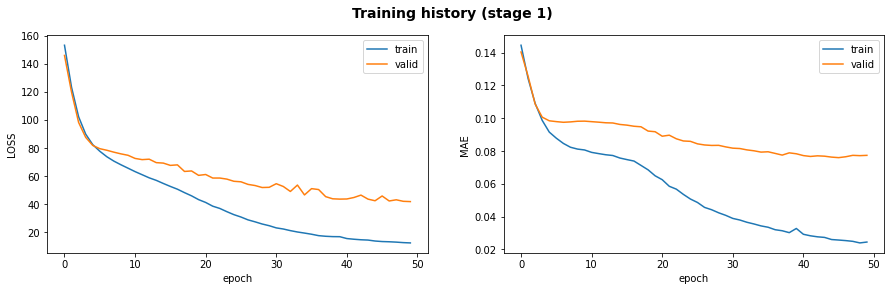

In [ ]:
with open('/content/gdrive/MyDrive/temp/train_history.pkl', 'wb') as handle:
  pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

train_hist = pickle.load(open("/content/gdrive/MyDrive/temp/train_history.pkl","rb"))

# we plot both, the LOSS and MAE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (stage 1)', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss'])
ax1.plot(train_hist['val_loss'])
ax1.set(xlabel='epoch', ylabel='LOSS')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae'])
ax2.plot(train_hist['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')
plt.show()

In [ ]:
# predict on the test data
predictions_2nd = model_101.predict(X_test, batch_size=32, verbose=1)

# re-scaling the output predictions (from [0,1] to age range) using the
# the normalization factor mentioned before
predictions_2nd_f = predictions_2nd*100

for i in range(0,10):
  print('predicted age = %.3f - Ground truth = %.3f' %(predictions_2nd_f[i], Y_test[i]))

62/62 [==============================] - 25s 354ms/step
predicted age = 19.144 - Ground truth = 23.205
predicted age = 48.374 - Ground truth = 70.737
predicted age = 35.524 - Ground truth = 55.368
predicted age = 27.094 - Ground truth = 24.278
predicted age = 19.502 - Ground truth = 25.231
predicted age = 25.803 - Ground truth = 35.179
predicted age = 22.872 - Ground truth = 26.923
predicted age = 43.452 - Ground truth = 48.189
predicted age = 25.275 - Ground truth = 18.676
predicted age = 47.521 - Ground truth = 57.378


Finally, we saved our results for the competition.

In [ ]:
import csv

# saving the predictions as a csv file
with open('predictions.csv', 'w') as csvFile:
  writer = csv.writer(csvFile)
  writer.writerows(predictions_2nd_f)
csvFile.close()

# compressing the csv file (to be submitted to codalab as prediction)
! zip predictions.zip predictions.csv

  adding: predictions.csv (deflated 55%)
